In [11]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_ollama import ChatOllama
llm =  ChatOllama(model="llama3.2", temperature=0.2)
from pydantic import BaseModel, Field
import operator ## incorporating reducer
from pprint import pprint

In [2]:
## defining structured schema

class EvaluationSchema(BaseModel):
    feedback: str = Field(description="Detailed feedback of the essay")
    score:int = Field(le=10,ge=0, description="Score out of 10")

structured_model = llm.with_structured_output(EvaluationSchema)

In [3]:
essay = """
The SIR (Special Identification and Removal) drive going on in West Bengal has become a very important issue in the state’s politics and society. It focuses on identifying people who are staying in India without proper legal documents and taking steps to remove them from the state. The SIR drive is a government campaign to identify illegal immigrants living in different parts of West Bengal. Officials check documents like voter ID, Aadhaar card, ration card, and land papers to see whether a person is a citizen or not. 
People who cannot show proper proof of citizenship may be marked as “doubtful” and asked to appear before authorities for further verification. This process is meant to separate genuine citizens from those who have entered the state from other countries without permission. The government and supporting political parties argue that illegal immigration changes the population balance and puts pressure on jobs, land, and welfare schemes. They say that if illegal immigrants get access to ration, health care, and government benefits, then genuine poor citizens get less share of these resources.


Some leaders also claim that illegal immigrants can be used as a “vote bank” by certain parties, which is unfair to legal voters and harms true democracy. For them, the SIR drive is a way to protect national security and ensure that only citizens decide the future of the state. On the other hand, many people are worried that genuine citizens might get harassed if their documents are old, lost, or not in proper form. In rural areas, many poor families do not have all records in order, so they fear being wrongly called illegal immigrants. Opposition parties and human rights groups say that such drives can create an atmosphere of fear among minorities and migrants. They also warn that families can be separated and daily wage earners may lose work if they spend time visiting offices and proving their identity. Socially, the SIR drive has increased tension between communities, as people start doubting who “belongs” and who does not. In some places, there are reports of arguments, discrimination, and even small clashes related to identity and documents. At the same time, some local residents feel more confident that the government is listening to their concerns about border security and population changes. Thus, the SIR drive is dividing public opinion, with some groups strongly supporting it and others strongly opposing it. The SIR drive is likely to play a big role in the upcoming Bengal state elections because political parties are using it as a major campaign issue. Parties that support the drive will ask voters to back them in the name of national security and protection of “original” citizens.

Opposition parties will try to gather support from people who feel targeted or scared by the drive and promise to stop or soften such measures. This may lead to very emotional speeches, sharp campaign slogans, and strong polarization of voters along community and identity lines.

In the end, the SIR drive may change voting patterns in border districts and areas with high migrant populations, as people decide their vote based on fear, security, and identity rather than only development issues. For a matriculation student observing these events, it shows how policies about citizenship and immigration can deeply affect both everyday life and the entire democratic process of a state.
"""

In [5]:
prompt = f"""Evaluate the language quality of following essay and provide a detailed feedback and assign a score out of 10: \n {essay}"""
structured_model.invoke(prompt)

EvaluationSchema(feedback="The essay provides a comprehensive analysis of the SIR drive in West Bengal, exploring its implications on politics, society, and citizens. The writer has done an excellent job of presenting multiple perspectives on the issue, including those of the government, opposition parties, human rights groups, and ordinary citizens. However, there are areas where the writing could be improved to enhance clarity, coherence, and overall language quality.\n\nThe essay is well-structured, with each paragraph focusing on a specific aspect of the SIR drive. The writer has used relevant examples and statistics to support their arguments, making the text more engaging and informative. However, some sentences are wordy or contain grammatical errors, which detract from the overall quality of the writing.\n\nOne area for improvement is in varying sentence structure and length. Many paragraphs consist of long, complex sentences that can be broken up into shorter, simpler ones to 

In [ ]:
class UPSC_State(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    indivisual_scores: Annotated[list[int],operator.add]  ## Reducer to incorporate output from multiple parallel node, merge list of outputs
    avg_score : float
    

In [16]:
def eval_language(state:UPSC_State)-> UPSC_State:
    prompt = f"""Evaluate the language quality of following essay and provide a detailed feedback and assign a score out of 10: \n {state['essay']}"""
    output = structured_model.invoke(prompt)
    return {'language_feedback':output.feedback,'indivisual_scores':[output.score]}

def eval_analysis(state:UPSC_State)-> UPSC_State:
    prompt = f"""Evaluate the depth of analysis of following essay and provide a detailed feedback and assign a score out of 10: \n {state['essay']}"""
    output = structured_model.invoke(prompt)
    return {'analysis_feedback':output.feedback,'indivisual_scores':[output.score]}

def eval_thought(state:UPSC_State)-> UPSC_State:
    prompt = f"""Evaluate the clarity of analysis of following essay and provide a detailed feedback and assign a score out of 10: \n {state['essay']}"""
    output = structured_model.invoke(prompt)
    return {'clarity_feedback':output.feedback,'indivisual_scores':[output.score]}

def eval_final(state:UPSC_State)-> UPSC_State:
    
    ##summary feedback
    prompt = f"""Based on the following feedback create bullet pointered summary of the essay that the candidate has written:
                langauge feedback :{state['language_feedback']} \n
                depth of analysis feedback :{state['analysis_feedback']} \n
                clarity of thought feedback :{state['clarity_feedback']}
                """
    final_feedback = llm.invoke(prompt).content
    
    ##average score
    avg_score = sum(state['indivisual_scores'])/len(state['indivisual_scores'])
    
    return {'overall_feedback':final_feedback, 'avg_score':avg_score}

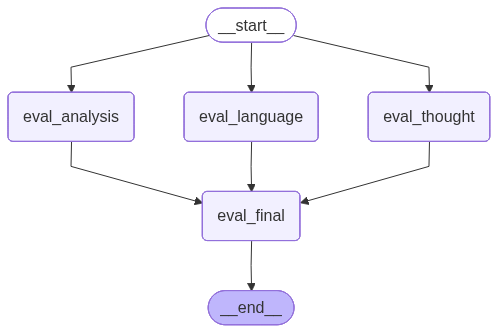

In [17]:
graph = StateGraph(UPSC_State)

## Add nodes
graph.add_node('eval_language',eval_language)
graph.add_node('eval_analysis',eval_analysis)
graph.add_node('eval_thought',eval_thought)
graph.add_node('eval_final',eval_final)

## add edges
graph.add_edge(START,'eval_language')
graph.add_edge(START,'eval_analysis')
graph.add_edge(START,'eval_thought')
graph.add_edge('eval_language','eval_final')
graph.add_edge('eval_analysis','eval_final')
graph.add_edge('eval_thought','eval_final')
graph.add_edge('eval_final',END)

workflow = graph.compile()

workflow

In [18]:
initial_state = {'essay':essay}
final_state = workflow.invoke(initial_state)

##display the state
print("\n🟦 INPUT STATE")
pprint(initial_state)

print("\n🟩 FINAL STATE")
pprint(final_state)


🟦 INPUT STATE
{'essay': '\n'
          'The SIR (Special Identification and Removal) drive going on in West '
          'Bengal has become a very important issue in the state’s politics '
          'and society. It focuses on identifying people who are staying in '
          'India without proper legal documents and taking steps to remove '
          'them from the state. The SIR drive is a government campaign to '
          'identify illegal immigrants living in different parts of West '
          'Bengal. Officials check documents like voter ID, Aadhaar card, '
          'ration card, and land papers to see whether a person is a citizen '
          'or not. \n'
          'People who cannot show proper proof of citizenship may be marked as '
          '“doubtful” and asked to appear before authorities for further '
          'verification. This process is meant to separate genuine citizens '
          'from those who have entered the state from other countries without '
          'pe